In [1]:
from pyprojroot import here
import rasterio
from rasterio.plot import show
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot

In [2]:
img = rasterio.open(here("./data/intermediate/PET/PETbrick_OGres.tif")) # NA values are -3.4e+38

/opt/anaconda3/envs/bplayground/lib/python3.8/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


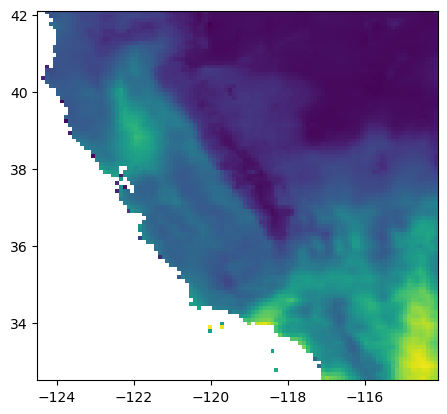

<AxesSubplot:>

In [3]:
show(img)

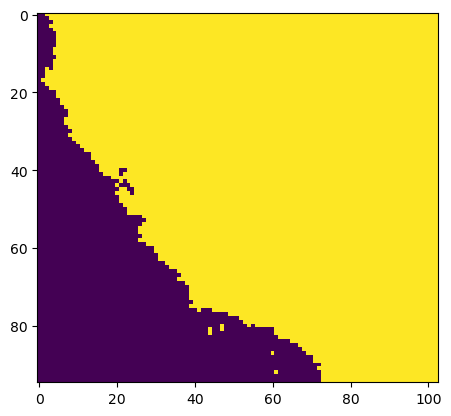

In [4]:
pyplot.imshow(img.read(1))
pyplot.show()

In [5]:
print(img.width, img.height, img.count) # I have 103 lat (rows), 95 lon (cols), and 703 days
array = np.array(img.read())
array.shape #date lon lat

103 95 731


(731, 95, 103)

In [6]:
# get a list of the start indices and end indices of each of your time intervals

# these are the dates of the images (bands) in order
base = datetime.date(day = 1, month = 1, year = 2019) #start Jan 1 2019
date_list = [base + datetime.timedelta(days=x) for x in range(img.count)]

# these are the start dates of the wanted time intervals
date_starts = [datetime.date(day = d, month = m, year = y) for y in (2019, 2020) for m in range(1, 13) for d in (1,15)]
del date_starts[5:9]
del date_starts[-3:-1]
del date_starts[-1]

# index of image on or nearest after start date
start_index = [date_list.index(min([i for i in date_list if i >= date_start], key=lambda x:x-date_start)) + 1 for date_start in date_starts] # plus one since bands are 1 indexed

# index of image on or nearest previous to start date + 61 days (this is for a non-inclusive index range so this date will be the first one not to be included in a subset)
end_index = [date_list.index(min([i for i in date_list if i <= date_start + datetime.timedelta(days=61)], key=lambda x:date_start+datetime.timedelta(days=61)-x)) + 1 for date_start in date_starts] # plus one since bands are 1 indexed

In [7]:
newarray = np.stack([array[start_index[i]:end_index[i]].mean(axis = 0) for i in range(0,len(start_index))], axis=0)
newarray.shape

/opt/anaconda3/envs/bplayground/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


(41, 95, 103)

In [17]:
metadata = img.profile
metadata['count'] = 41

In [18]:
# write your new raster
with rasterio.open(here("./data/intermediate/PET/PET_rolling_avg_OGres.tif"), 'w', **metadata) as dst:
    dst.write(newarray)